## Journal used for the implemetation
Journal title: Facial Expression Recognition using Convolutional
Neural Network with Data Augmentation

Authors: Tawsin Uddin Ahmed, Sazzad Hossainy, Mohammad Shahadat Hossainz, Raihan Ul Islamx and Karl Andersson

Journal Name: Joint 2019 8th International Conference on Informatics, Electronics & Vision (ICIEV) &
3rd International Conference on Imaging, Vision & Pattern Recognition (IVPR)

Year: 2019

# 1. Import the required libraries

In [ ]:
##---------Type the code below this line------------------##

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils import plot_model
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import shutil
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 2. Data Acquisition

For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



In [ ]:
##---------Type the code below this line------------------##
#Dataset downloaded from: https://www.kaggle.com/msambare/fer2013 in google drive
#Data is cleansed to remove some of the invalid data as mentioned in the paper
#In the paper other datasets were also mentioned, but none of them were publically accessible except FER2013, so we used FER2013 dataset only
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/Datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Datasets


# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

In [ ]:
## Identify the target variables.
##---------Type the code below this line------------------##
# We need to classify the test images in the below class labels of expressions
class_labels=['Angry','Happy','Neutral','Disgust','Fear','Sad','Surprise']

# Apply crop faces method for preprocessing the images as mentioned in the research paper
def cropFaces(fer2013_folder, output_folder):
  # Initialize the Haar Cascade Classifier for face detection
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  if not os.path.isdir(output_folder):
    # Create a folder to save the cropped face images
    os.makedirs(output_folder, exist_ok=True)
    # Iterate through the emotion folders and process each image
    for emotion_folder in os.listdir(fer2013_folder):
        emotion_path = os.path.join(fer2013_folder, emotion_folder)

        # Ensure that the item in the folder is indeed a directory
        if not os.path.isdir(emotion_path):
            continue

        os.makedirs(os.path.join(output_folder,emotion_folder), exist_ok=True)
        # Iterate through the images in the emotion folder
        for image_filename in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_filename)

            # Load the image
            img = cv2.imread(image_path)

            # Convert to grayscale for face detection (assuming the image is in color)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # detects faces in the input image
            faces = face_cascade.detectMultiScale(gray, 1.05, 3, minSize=(25, 25))

            if len(faces) > 0:
                # Get the coordinates of the first detected face
                x, y, w, h = faces[0]

                # Crop the face region
                face = img[y:y + h, x:x + w]

                # Save the cropped face image with an appropriate filename
                filename = os.path.join(output_folder,emotion_folder, image_filename)
                cv2.imwrite(filename, face)

#Detect faces and crop for all image
cropFaces(fer2013_folder='fer13-cleaned',output_folder='fer13cropped')

## Split the data into training set and testing set

##---------Type the code below this line------------------##
# 80% train and 20% test as mentioned in the paper
train_data_dir='fer13cropped'
test_data_dir='fer13cropped-test'
if not os.path.isdir(test_data_dir):
  # Specify the percentage of images to move to the test dataset (e.g., 10%)
  percentage_to_test = 20

  # Iterate through the emotion folders in the train dataset
  for emotion_folder in os.listdir(train_data_dir):
      emotion_path = os.path.join(train_data_dir, emotion_folder)

      # Ensure that the item in the folder is indeed a directory
      if not os.path.isdir(emotion_path):
          continue
      # Create the corresponding emotion folder in the test dataset if it doesn't exist
      test_emotion_folder = os.path.join(test_data_dir, emotion_folder)
      os.makedirs(test_emotion_folder, exist_ok=True)
      # Get a list of all image files in the emotion folder
      image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

      # Calculate the number of images to move to the test dataset
      num_images_to_move = int(len(image_files) * (percentage_to_test / 100))

      # Randomly select images to move to the test dataset
      test_images = random.sample(image_files, num_images_to_move)



      # Move the selected images to the test dataset
      for image_file in test_images:
          src_path = os.path.join(emotion_path, image_file)
          dest_path = os.path.join(test_emotion_folder, image_file)
          shutil.move(src_path, dest_path)

print("Test dataset creation completed.")


Test dataset creation completed.


Report the feature representation that is being used for training the model.


Found 7547 images belonging to 7 classes.
Found 1883 images belonging to 7 classes.


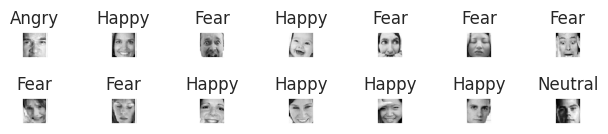

In [ ]:
##---------Type below this line------------------##
## Data Augmentation
IMG_HEIGHT=48
IMG_WIDTH = 48
batch_size=32
train_data_dir='fer13cropped'
validation_data_dir='fer13cropped-test/'
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.2,
					zoom_range=0.2,
					horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

#Verify our generator by plotting a few faces and printing corresponding labels
for j in range(14):
  img, label = validation_generator.__next__()

  import random

  i=random.randint(0, (img.shape[0])-1)
  image = img[i]
  labl = class_labels[label[i].argmax()]
  ax = plt.subplot(7, 7, j+1)
  ax.imshow(image[:,:,0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(labl)
  plt.tight_layout()

## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



In [ ]:
##---------Type the code below this line------------------##
###########################################################
# Define the model
model = Sequential()

# First Convolution Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolution Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolution Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from convolutional layers
model.add(Flatten())

# First Fully Connected Layer
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.5))

# Second Fully Connected Layer
model.add(Dense(850, activation='relu'))
model.add(Dropout(0.5))

# Third Fully Connected Layer
model.add(Dense(850, activation='relu'))
model.add(Dropout(0.5))

# Fourth Fully Connected Layer
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7, activation='softmax'))


## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters



In [ ]:
##---------Type the answer below this line------------------##
# model summary shows
print(model.summary())
print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

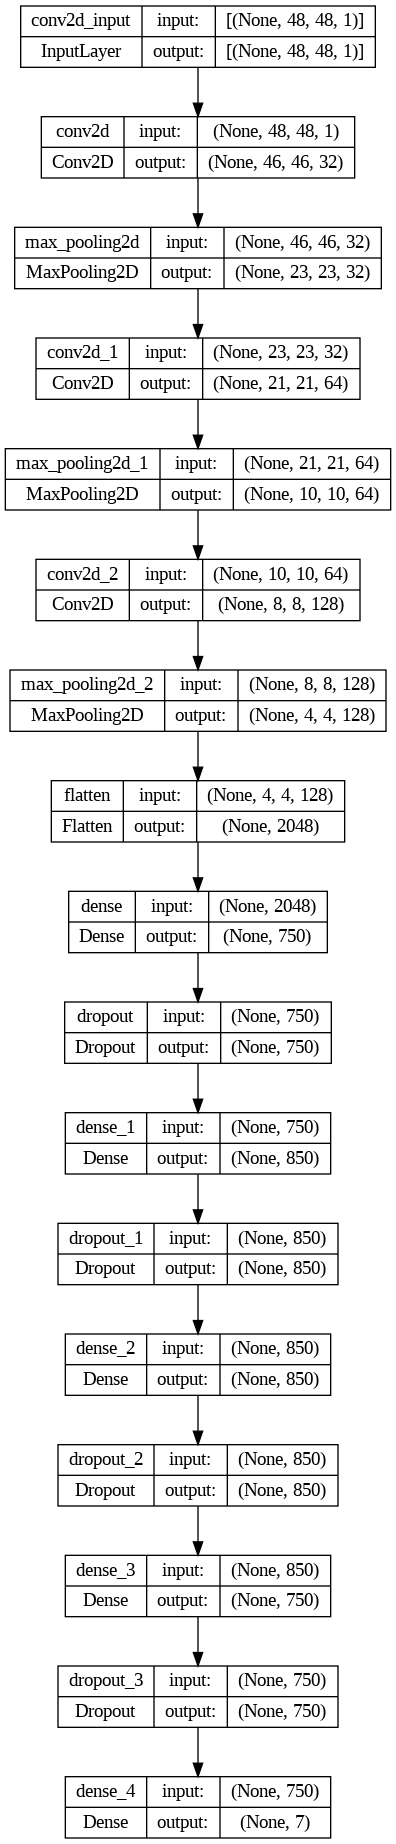

In [ ]:
# Specify the file path to save the model plot as an image
plot_file_path = 'model_plot.png'

# Plot the model architecture and save it as an image
plot_model(model, to_file=plot_file_path, show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='model_plot.png')

| Parameter                         | Number                  | Justification                                                                                          |
|-----------------------------------|-------------------------|--------------------------------------------------------------------------------------------------------|
| **Number of Layers**              |                         |                                                                                                        |
| Input Layer                       | 1                       | The input layer accepts grayscale images with a size of 48x48 pixels.                                   |
| Convolutional Layers              | 3                       | We have 3 convolutional layers for feature extraction.                                                 |
| Max Pooling Layers                | 3                       | We use 3 max-pooling layers for down-sampling.                                                         |
| Fully Connected (Dense) Layers    | 4                       | There are 4 dense layers for classification.                                                           |
| Dropout Layers                    | 4                       | We have 4 dropout layers to prevent overfitting.                                                       |
| Flatten Layer                     | 1                       | The flatten layer transforms the 3D output of the previous layer into a 1D vector.                    |
| Output Layer                      | 1                       | The output layer has 1 unit for each class (7 classes).                                               |
| **Total Number of Layers**        | 17                      | The total number of layers in the model is 17.                                                         |
| **Number of Units in Each Layer** |                         |                                                                                                        |
| First Convolutional Layer         | 32 units                | The first convolutional layer has 32 units for feature extraction.                                     |
| Second Convolutional Layer        | 64 units                | The second convolutional layer has 64 units for more complex features.                                  |
| Third Convolutional Layer         | 128 units               | The third convolutional layer has 128 units to capture deeper features.                                 |
| Flatten Layer                     |                         | The flatten layer transforms the 3D output of the previous layer into a 1D vector.                    |
| First Fully Connected Layer       | 750 units               | The first fully connected layer contains 750 units for pattern learning.                                |
| First Dropout Layer               | 50% dropout rate        | The first dropout layer randomly drops 50% of neurons to prevent overfitting.                           |
| Second Fully Connected Layer      | 850 units               | The second fully connected layer includes 850 units for further abstraction.                             |
| Second Dropout Layer              | 50% dropout rate        | The second dropout layer randomly drops 50% of neurons.                                                 |
| Third Fully Connected Layer       | 850 units               | The third fully connected layer has 850 units for complex patterns.                                     |
| Third Dropout Layer               | 50% dropout rate        | The third dropout layer randomly drops 50% of neurons.                                                 |
| Fourth Fully Connected Layer      | 750 units               | The fourth fully connected layer contains 750 units.                                                   |
| Fourth Dropout Layer              | 50% dropout rate        | The fourth dropout layer randomly drops 50% of neurons.                                                |
| Output Layer                      | 7 units                 | The output layer consists of 7 units, one for each class in the classification task.                  |
| **Total Trainable Parameters**    | 3,634,629 parameters    | The total number of trainable parameters in the model is 3,634,629 parameters.         |


# 5. Training the model


In [ ]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions
##---------Type the code below this line------------------##
# Define the optimizer (Stochastic Gradient Descent)
optimizer = SGD(learning_rate=0.01)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6),
    ModelCheckpoint('model_weights.h5', save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='logs')
]



train_path = "fer13cropped"
test_path = "fer13cropped-test"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

##Training the model

epochs=50

# Initialize variables to control retries and total epochs
max_retries =5 # Maximum number of retries
max_epochs = 50  # Maximum number of epochs per retry
total_epochs = 0  # Total number of epochs trained

while max_retries>0:
    try:
        # Check if the checkpoint file exists and load model weights if it does
        if os.path.exists('model_weights.h5'):
            model.load_weights('model_weights.h5')


        # Example: Compiling and training the model for the remaining epochs
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(
            train_generator,
            steps_per_epoch=num_train_imgs//batch_size,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=num_test_imgs//batch_size,
            callbacks=callbacks
        )



        # If training completes successfully, break out of the loop
        break

    except Exception as e:
        # Handle exceptions gracefully
        print("An exception occurred:", str(e))
        print("Restarting training from the last checkpoint...")

        # Increment the total retries and epochs
        max_retries-=1  # Consider all remaining epochs for this retry


Epoch 1/50
235/235 [==============================] - 82s 334ms/step - loss: 0.9023 - accuracy: 0.6582 - val_loss: 0.7942 - val_accuracy: 0.7134
Epoch 2/50
235/235 [==============================] - 72s 308ms/step - loss: 0.8818 - accuracy: 0.6584 - val_loss: 0.8001 - val_accuracy: 0.7150
Epoch 3/50
235/235 [==============================] - 68s 288ms/step - loss: 0.9071 - accuracy: 0.6547 - val_loss: 0.8156 - val_accuracy: 0.7069
Epoch 4/50
235/235 [==============================] - 75s 320ms/step - loss: 0.9031 - accuracy: 0.6599 - val_loss: 0.7940 - val_accuracy: 0.7069
Epoch 5/50
235/235 [==============================] - 75s 319ms/step - loss: 0.9104 - accuracy: 0.6488 - val_loss: 0.7873 - val_accuracy: 0.7252
Epoch 6/50
235/235 [==============================] - 75s 320ms/step - loss: 0.8972 - accuracy: 0.6536 - val_loss: 0.8086 - val_accuracy: 0.6902
Epoch 7/50
235/235 [==============================] - 74s 313ms/step - loss: 0.9029 - accuracy: 0.6548 - val_loss: 0.7940 - val_ac

# 6. Test the model


In [ ]:
##---------Type the code below this line------------------##
#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)
print (f"Actual:    {[class_labels[t] for t in test_labels]}")
print (f"Predicted: {[class_labels[t] for t in predictions]}")
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

1/1 [==============================] - 0s 62ms/step
Actual:    ['Neutral', 'Happy', 'Happy', 'Neutral', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Fear', 'Angry', 'Happy', 'Happy', 'Neutral', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Fear', 'Happy', 'Happy', 'Neutral', 'Angry', 'Happy', 'Angry', 'Fear', 'Happy', 'Happy', 'Fear', 'Happy']
Predicted: ['Neutral', 'Happy', 'Happy', 'Neutral', 'Neutral', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Fear', 'Angry', 'Happy', 'Happy', 'Neutral', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Neutral', 'Happy', 'Happy', 'Happy', 'Angry', 'Happy', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']
Accuracy =  0.84375


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "FER2013 Training vs Validation accuracy,loss plots" \
  --description "Training results from https://colab.research.google.com/drive/1Q61ZYA_YVc5aDQXN4Ruaq4FUiIt77B1I?authuser=2#scrollTo=GV26_JBPmxUJ" \
  --one_shot

2023-09-09 11:35:14.785965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/1Lks4ZQoRPa0Es4GX6f30g/

[2023-09-09T11:35:17] Started scanning logdir.
E0909 11:35:18.715960 132860429385728 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0909 11:35:19.767178 132860429385728 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0909 11:35:20.740424 132860429385728 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0909 11:35:21.725366 132860429385728 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0909 11:35:22.724948 132860429385728 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0909 11:35:23.758740 132860429385728 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0909 11:35:24.724440 132860429385728 uploader.py:1122] Attempted to re-upload existing 

**Both of the plots training and validation accuracy and loss are available at TensorBoard at** https://tensorboard.dev/experiment/1Lks4ZQoRPa0Es4GX6f30g/

**Epochs(x) vs Accuracy(y) of training(red) and Validation (blue)**

</img>

**Epochs(x) vs Loss(y) of training(red) and Validation (blue)**

 </img>

###Report the testing accuracy and loss.



In [ ]:
# Evaluate the model using the validation generator
validation_results = model.evaluate(validation_generator)

# The `validation_results` variable will contain the loss and accuracy
test_loss = validation_results[0]
test_accuracy = validation_results[1]

# Report the test loss and accuracy
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

59/59 [==============================] - 7s 120ms/step - loss: 0.7662 - accuracy: 0.7228
Test Loss: 0.7662
Test Accuracy: 0.7228


### Confusion Matrix for Testing Dataset

59
59/59 [==============================] - 2s 39ms/step


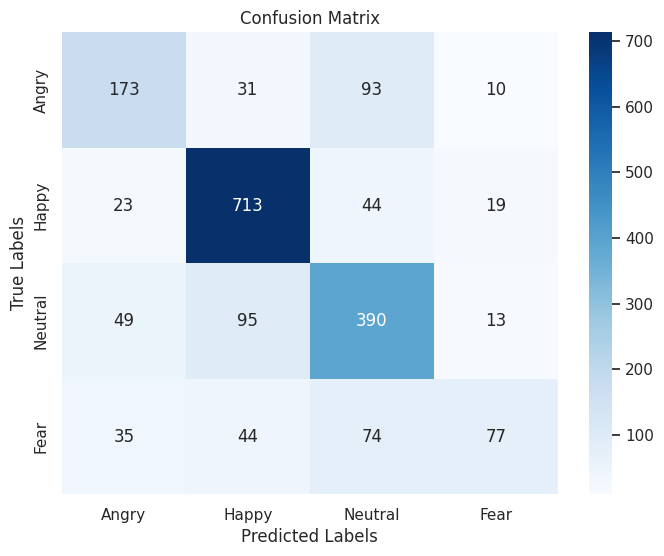

In [ ]:
##---------Type the code below this line------------------##
# Generate predictions for the validation dataset using the model

# Initialize empty lists to collect data and labels
all_data = []
all_labels = []

# Calculate the total number of batches
total_batches = len(validation_generator)
print (total_batches)
# Iterate through the generator to collect data and labels
for _ in range(total_batches):
    data_batch, labels_batch = next(validation_generator)
    all_data.extend(data_batch)
    all_labels.extend(labels_batch)

# Convert the lists to NumPy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)
y_pred = model.predict(all_data)
y_pred = np.argmax(y_pred, axis=1)
test_labels = np.argmax(test_lbl, axis=1)
# Extract true labels from the validation generator
y_true = all_labels  # Use classes attribute to get true labels
y_true = np.argmax(y_true, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true , y_pred)


# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Angry','Happy','Neutral','Fear'],
            yticklabels=['Angry','Happy','Neutral','Fear'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Calculate classification report (accuracy, precision, recall, F1 Score)


In [ ]:
classification_rep = classification_report(y_true, y_pred, target_names=['Angry','Happy','Neutral','Fear'])
# Report the classification report
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.56      0.59       307
       Happy       0.81      0.89      0.85       799
     Neutral       0.65      0.71      0.68       547
        Fear       0.65      0.33      0.44       230

    accuracy                           0.72      1883
   macro avg       0.68      0.63      0.64      1883
weighted avg       0.71      0.72      0.71      1883

